# Feature Engineering

In [2]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [3]:
from scipy.stats.mstats import winsorize

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  

In [4]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [5]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

## Información de los datasets

In [6]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [7]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [8]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


# Aplicamos transformaciones

In [9]:
# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

In [10]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# this function takes a dataframe as input and
# returns a modified version thereof
def select_columns_iloc(input_df,range_columns):
    output_df = input_df.iloc[:,range_columns[0]:range_columns[1]]
    return output_df

def drop_columns(input_df,columns):
    output_df = input_df.copy()
    for column_name in columns:
        output_df = output_df.drop(labels=column_name,axis=1)
    return output_df

def winsorize_columns(input_df,columns_to_winsorize,ranges_winsorize):
    for i in range(len(columns_to_winsorize)):
        columna_winsorize = winsorize(input_df[columns_to_winsorize[i]],ranges_winsorize[i])
        input_df[columns_to_winsorize[i]] = columna_winsorize
    return input_df

def get_dummies_transform(input_df):
    return pd.get_dummies(input_df)

#auxiliar
def nombre_nueva_mean_col(col_name,damage_grade):
    damage_names = {1:'low',2:'medium',3:'high'}
    return 'mean_'+damage_names[damage_grade]+'_damage_'+col_name

#generalizar para una columna
def agregar_col_mean_daño_por_columna(input_df,labels_df,col_name,damage_grade):
    """Agrega una columna llamada mean_damage_'col_name' con el mean damage para el daño 'damage_grade'"""
    work_df = input_df[[col_name]].copy()
    work_df = work_df.join(labels_df,on='building_id',how='inner')
    work_df['count_damage_i'] = work_df['damage_grade'] == damage_grade
    new_col_name = nombre_nueva_mean_col(col_name,damage_grade)
    input_df[new_col_name] = work_df.groupby(col_name).transform('mean')['count_damage_i']
    return input_df


In [11]:
#Ajustes iniciales
pipeline_inicial = Pipeline([
    ("drop_has_sec_variants", FunctionTransformer(select_columns_iloc,kw_args={'range_columns':(0,28)})),
    ("drop_plan_config", FunctionTransformer(drop_columns,kw_args={'columns': ['plan_configuration']})),
    ("winsorize", FunctionTransformer(winsorize_columns,kw_args={'columns_to_winsorize': ['age','area_percentage','height_percentage'],
                                                                'ranges_winsorize': [(0,0.03),(0,0.03),(0,0.06)]})),
])
# Probar al final si sacarlos obtengo mejor score.

In [12]:
#Mean col geo
steps_daños = []
for geo_level_id in range(1,4):
    for damage_grade in range(1,4):
        nombre_step = 'add_damage_'+str(damage_grade)+'_geo_'+str(geo_level_id)
        args = {'labels_df': train_labels,'col_name': 'geo_level_'+str(geo_level_id)+'_id','damage_grade':damage_grade}
        steps_daños.append((nombre_step,FunctionTransformer(agregar_col_mean_daño_por_columna,kw_args=args)))

In [13]:
pipeline_daños = Pipeline(steps=steps_daños)
#pipeline_daños

In [14]:
#Mean col area
steps_area = []
for damage_grade in range(1,4):
    nombre_step = 'add_damage_'+str(damage_grade)+'_height'
    args = {'labels_df': train_labels,'col_name': 'area_percentage','damage_grade':damage_grade}
    steps_area.append((nombre_step,FunctionTransformer(agregar_col_mean_daño_por_columna,kw_args=args)))

In [15]:
pipeline_area= Pipeline(steps=steps_area)

### Aplico transformaciones

In [16]:
train_values_transformado = pipeline_inicial.fit_transform(train_values)

In [17]:
train_values_transformado = pipeline_daños.fit_transform(train_values_transformado)

In [18]:
train_values_transformado = pipeline_area.fit_transform(train_values_transformado)

In [19]:
train_values_transformado = pd.get_dummies(train_values_transformado)

In [20]:
train_values_transformado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 60 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          260601 non-null  int16  
 1   geo_level_2_id                          260601 non-null  int16  
 2   geo_level_3_id                          260601 non-null  int16  
 3   count_floors_pre_eq                     260601 non-null  int16  
 4   age                                     260601 non-null  int16  
 5   area_percentage                         260601 non-null  int16  
 6   height_percentage                       260601 non-null  int16  
 7   has_superstructure_adobe_mud            260601 non-null  bool   
 8   has_superstructure_mud_mortar_stone     260601 non-null  bool   
 9   has_superstructure_stone_flag           260601 non-null  bool   
 10  has_superstructure_cement_mortar_stone 

XGBoost

In [21]:
import xgboost as xgb
import time
from datetime import datetime
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import sys

In [22]:
from sklearn.utils.class_weight import compute_sample_weight

In [28]:
space = {
        'n_estimators':hp.choice('n_estimators', np.arange(100, 400, 10, dtype=int)),
        'max_depth':hp.choice('max_depth', np.arange(6,14, 1, dtype=int)),
        'gamma':hp.quniform('gamma', 0, 5, 0.5),
        'max_delta_step':hp.choice('max_delta_step', np.arange(0,5, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(0.5, 3, 0.5, dtype=int)),
        'subsample':hp.quniform('subsample', 0.5, 1, 0.1),
        'eta':hp.quniform('eta', 0.1, 1, 0.1),
        'objective':'multi:softmax',
        'eval_metric': 'mlogloss',
    }

In [29]:
important_parameters = ['n_estimators','max_depth','colsample_bytree','min_child_weight','subsample','eta']

In [30]:
def objective_function(params):
    clf = xgb.XGBClassifier(**params)
    score = cross_val_score(clf, train_values_transformado, train_labels.values.ravel(), cv=5,verbose=10).mean()
    #Save best params now
    mensaje_output = f'{datetime.now().strftime("%d/%m/%Y, %H:%M:%S")} --- Score: {score}--- ---'
    params = clf.get_params()
    local_opt = []
    for parameter in important_parameters:
        local_opt.append((parameter,params.get(parameter)))
    with open('best_param_allnight.txt',mode='a') as fd:
        fd.write(mensaje_output+'\n')
        fd.write(f"Parametros-{str(local_opt)}")
        fd.write("\n")
    print(mensaje_output)
    return {'loss': -score, 'status': STATUS_OK}

In [31]:
trials = Trials()

In [ ]:
best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=120, trials=trials)

In [ ]:
print(best_param)

In [ ]:
pprint(trials.trials)

In [45]:
import pickle

In [46]:
#pickle.dump(trials, open("hyperopt.p", "wb"))
trials = pickle.load(open("hyperopt.p", "rb"))

In [ ]:
trials2.trials

In [47]:
def unpack(x):
    if x:
        return x[0]
    return np.nan
# We'll first turn each trial into a series and then stack those series together as a dataframe.
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials.trials[:-1]])
# Then we'll add other relevant bits of information to the correct rows and perform a couple of
# mappings for convenience

trials_df["loss"] = [t["result"]["loss"] for t in trials.trials[:-1]]
trials_df["trial_number"] = trials_df.index

In [48]:
pd.options.display.float_format = "{:,.4f}".format

In [49]:
trials_df["n_estimators"] = trials_df["n_estimators"].apply(lambda x:(x+10)*10)
trials_df["max_depth"] = trials_df["max_depth"].apply(lambda x:x+6)
trials_df = trials_df.rename(columns={'loss':'score','eta':'learning_rate'})
trials_df = trials_df.set_index('trial_number')

In [121]:
trials_df[['score','max_depth','n_estimators','learning_rate','gamma','subsample','max_delta_step','colsample_bytree','min_child_weight']].sort_values('score').head(10)

,score,max_depth,n_estimators,learning_rate,gamma,subsample,max_delta_step,colsample_bytree,min_child_weight
trial_number,,,,,,,,,
21,-0.7630,13.0000,330.0000,0.1000,5.0000,0.9000,1.0000,0.5000,1.0000
36,-0.7629,9.0000,340.0000,0.1000,3.0000,0.9000,0.0000,0.9000,2.0000
3,-0.7627,9.0000,330.0000,0.1000,2.5000,0.9000,4.0000,1.0000,2.0000
31,-0.7626,13.0000,130.0000,0.1000,4.5000,0.8000,1.0000,0.8000,3.0000
22,-0.7626,10.0000,330.0000,0.1000,5.0000,0.9000,1.0000,0.8000,1.0000
37,-0.7622,13.0000,340.0000,0.1000,3.5000,0.9000,0.0000,0.9000,0.0000
42,-0.7622,12.0000,290.0000,0.2000,5.0000,0.9000,1.0000,1.0000,0.0000
32,-0.7621,10.0000,150.0000,0.3000,5.0000,0.9000,3.0000,0.6000,1.0000
26,-0.7620,9.0000,100.0000,0.1000,4.5000,0.9000,4.0000,0.6000,1.0000


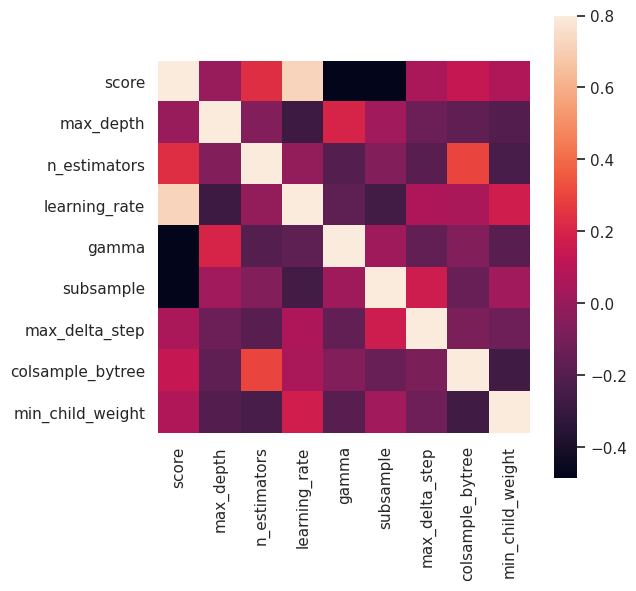

In [134]:
corrmat = trials_df[['score','max_depth','n_estimators','learning_rate','gamma','subsample','max_delta_step','colsample_bytree','min_child_weight']].corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax=.8, square=True);

array([<AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>], dtype=object)

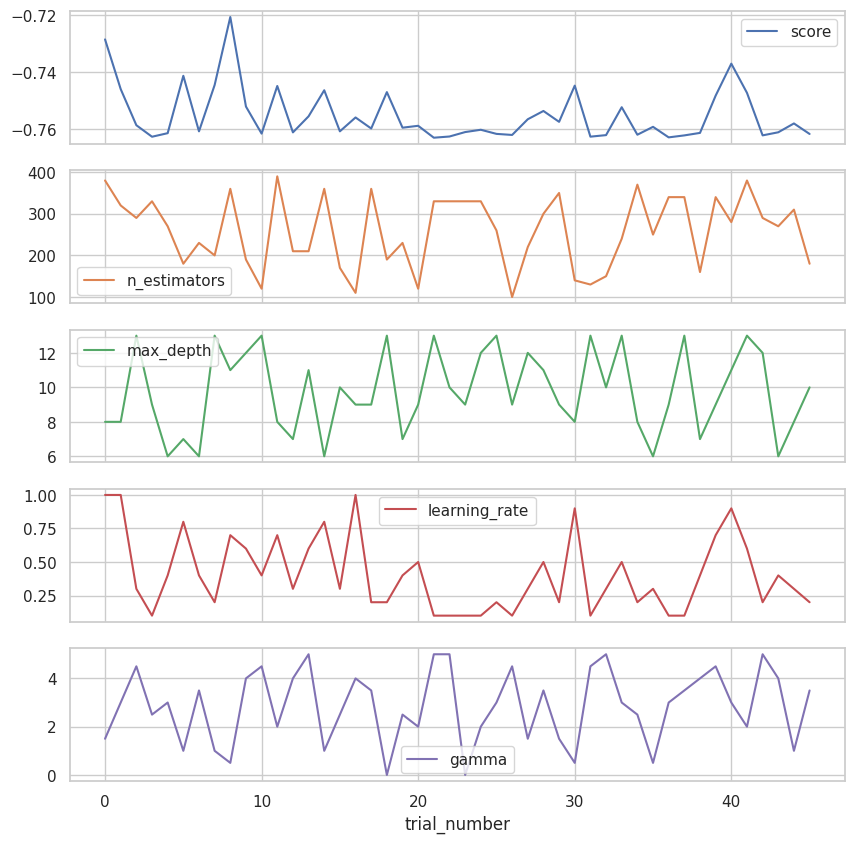

In [128]:
trials_df[['score','max_depth','n_estimators','learning_rate','gamma']].plot(subplots=True,figsize=(10,10))

array([<AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>], dtype=object)

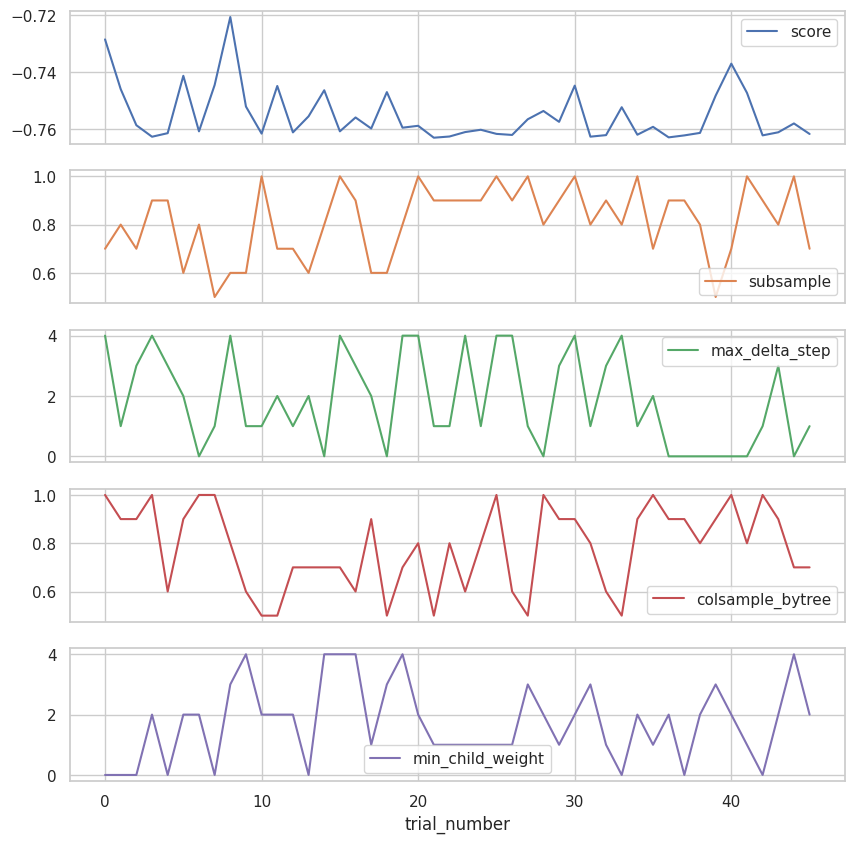

In [129]:
trials_df[['score','subsample','max_delta_step','colsample_bytree','min_child_weight']].plot(subplots=True,figsize=(10,10))

## Random Grid Seach

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
# Para guardarlo en un archivo
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()

In [29]:
params = {
        'n_estimators': np.arange(290, 355, 5, dtype=int),
        'max_depth':np.arange(9, 15, 1, dtype=int),
        'gamma':np.linspace(3,6,7),
        'max_delta_step': np.arange(0,5, 1, dtype=int),
        'colsample_bytree': np.linspace(0.9,1,2),
        'min_child_weight':np.linspace(1,3,5),
        'subsample':np.linspace(0.9,1,2),
        'eta':[0.1],
        }

In [30]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob",
                              eval_metric='mlogloss')

In [31]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    scoring = 'f1_micro',
    n_jobs = 1,
    cv = 5,
    n_iter=40,
    verbose=10
)

In [ ]:
logfile = open('randomSearch_final.txt', 'w')
original_stderr = sys.stderr
original_stdout = sys.stdout
sys.stdout = Tee(sys.stdout, logfile)
sys.stderr = sys.stdout

#Inicio#
random_search.fit(train_values_transformado,train_labels.values.ravel())
## Fin
sys.stdout = original_stdout
sys.stderr = original_stderr
logfile.close()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START colsample_bytree=0.9, eta=0.1, gamma=4.0, max_delta_step=0, max_depth=13, min_child_weight=2.5, n_estimators=305, subsample=0.9
[CV 1/5; 1/40] END colsample_bytree=0.9, eta=0.1, gamma=4.0, max_delta_step=0, max_depth=13, min_child_weight=2.5, n_estimators=305, subsample=0.9;, score=0.763 total time= 6.0min
[CV 2/5; 1/40] START colsample_bytree=0.9, eta=0.1, gamma=4.0, max_delta_step=0, max_depth=13, min_child_weight=2.5, n_estimators=305, subsample=0.9
[CV 2/5; 1/40] END colsample_bytree=0.9, eta=0.1, gamma=4.0, max_delta_step=0, max_depth=13, min_child_weight=2.5, n_estimators=305, subsample=0.9;, score=0.759 total time= 6.0min
[CV 3/5; 1/40] START colsample_bytree=0.9, eta=0.1, gamma=4.0, max_delta_step=0, max_depth=13, min_child_weight=2.5, n_estimators=305, subsample=0.9
[CV 3/5; 1/40] END colsample_bytree=0.9, eta=0.1, gamma=4.0, max_delta_step=0, max_depth=13, min_child_weight=2.5, n_estimators=305

In [ ]:
raise ValueError('FINALIZO EL ALGORITMO')

## Si funciona

In [78]:
#
xgb_model = xgb.XGBClassifier(objective="multi:softprob",
                              eval_metric='mlogloss')

In [79]:
start_time = time.time()
train_values_subset = train_values_transformado
#scores_best_norm = cross_val_score(xgb_model, train_values_transformado, train_labels.values.ravel())
xgb_model.fit(train_values_subset,train_labels.values.ravel() )
print("--- Duración: %s segundos ---" % (time.time() - start_time))
#print(scores_best_norm)
#print(scores_best_norm.mean())

--- Duración: 184.53256678581238 segundos ---


In [80]:
pprint(xgb_model.get_params())

Pretty printing has been turned OFF


In [101]:
y_pred = xgb_model.predict(train_values_subset)
f1_score(train_labels, y_pred, average='micro')

0.7830207865664369

In [82]:
# import pickle
# filename = 'modelos/xgb_modelo_7444.sav'
# pickle.dump(xgb_model, open(filename, 'wb'))

**Pruebas raras**:
* Si tiene la misma cantidad de columnas con el cual se entrenó el algoritmo -> lo va a predecir (Ojo)  

Registro de scores (random_state = 99, con objective=multi:softmax y eval_metric= mlogloss sin nada más):  
**GENERALES**
* Con todos los features y one-hot-encoding -> 0.7442
* Con todos los features (OHE) y normalización (StandardScaler) -> 0.7452
* Con todos los features (OHE) y normalización (MinMaxScaler) -> 0.7452  



**Eliminación de columnas**  
* Sin plan_configuration : 0.7447
* Sin has_secondary específicos y sin plan_configuration : Score: 0.7467 Score Test: 0.7304
* Sin has_secondary (ninguno) -> 0.7440
* Sin plan configuration -> 0.7442
* Sin has_secondary (ninguno) y sin legal_ownership_status-> 0.7437
* Sin has_secondary específicos -> 0.743922
* Sin has_secondary específicos y sin plan configuration ->0.7456
* Lo mismo que el anterior pero ahora sin plan_configuration -> 0.7412  

**Sin has_secondary específicos ni plan_configuration- Objetivo>0.7467** (Mejorar no hacer nada):  
* Con winsorizing para age:0.05 , area_percentage:0.06 , height_percentage:0.02. Score entr:0.7457
* Con winsorizing para age:0.01 , area_percentage:0.06 , height_percentage:0.02. Score entr:0.7454 -> legal_ownership_status
* Con winsorizing para age:0.03 , area_percentage:0.03 , height_percentage:0.06. Score entr:0.7473 Score Test:0.7307

**Pruebo sin sacar columnas**
* Con winsorizing para age:0.03 , area_percentage:0.03 , height_percentage:0.06. Score entr:0.7448

**Target encoding damage**
* geo_level_1_id -> score:0.7463
* geo_level_2_id -> score:0.7529
* geo_level_3_id -> score:0.7689
* geo_level_1_id + geo_level_2_id: 0.7531
* geo_level_1_id + geo_level_2_id + geo_level_3_id -> Train score:  0.7690. Test Score: 0.7409
* geo_level_id todos los daños y todos los id: 0.7766, Test Score: 0.7444
* mean damages superstructure->: 0.7460
* geo_level_id (todos) + superstructure (todos) -> 0.7768, Test Score: 0.7428

## Predecir el set de test de DrivenData

Tenemos que predecir nuevos valores de los que desconocemos sus labels o daños.  
Solo tenemos sus columnas o features. Vamos a utilizar nuestro modelo para predecir.

In [102]:
test_values = pd.read_csv('datos/test_values.csv', index_col='building_id')

In [103]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   geo_level_1_id                          86868 non-null  int64 
 1   geo_level_2_id                          86868 non-null  int64 
 2   geo_level_3_id                          86868 non-null  int64 
 3   count_floors_pre_eq                     86868 non-null  int64 
 4   age                                     86868 non-null  int64 
 5   area_percentage                         86868 non-null  int64 
 6   height_percentage                       86868 non-null  int64 
 7   land_surface_condition                  86868 non-null  object
 8   foundation_type                         86868 non-null  object
 9   roof_type                               86868 non-null  object
 10  ground_floor_type                       86868 non-null  object
 

El set de test tiene que tener el MISMO formato que usamos para entrenar.  
Es decir, si le hicimos algunas modificaciones en las columnas al set de entrenamiento, también tenemos que hacerlas al set de test.  
En este caso, solo seleccionamos algunas columnas y utilizamos One-Hot-Encoding para las variables categóricas (sget_dummies)

Trasformar el set de test

In [104]:
def agregar_columna_mean_damage(input_df,column_name,train_values,train_labels,damage_grade):
    """Recibe un df y calcula la media de daño 'damage_grade' para cada valor distinto de 'column_name' 
    """
    # Copio el df inicial para calcular mean sin afectar al input
    df = train_values.copy()
    df = df[[column_name]]
    df = df.join(train_labels,on='building_id',how='inner')
    
    # Se le agrega una columna a df con 1 si el edificio recibio daño del tipo 'damage_grade',0 si no
    df['count_damage_i'] = df['damage_grade'] == damage_grade
    
    # mean damage es un df con indice 'column_name' y como unica columna 'count_high_damage'
    mean_damage = df.groupby(column_name).agg('mean')[['count_damage_i']]
    
    # output df es el df inicial pero ahora con una nueva columna con los daños medios para cada elemento
    # de la columna 'column_name'
    output_df = input_df.join(mean_damage,on=column_name,how='left',)
    nombre_nueva_col = nombre_nueva_mean_col(column_name,damage_grade)
   
    # ahora esa columna tiene el nombre 'nombre_nueva_col'
    output_df = output_df.rename(columns={'count_damage_i': nombre_nueva_col})
    
    # manejo de nulls -> agrego la media global de ese nombre_nueva_col si es null 
    mean_global = output_df[nombre_nueva_col].mean()
    output_df[nombre_nueva_col] = output_df[nombre_nueva_col].fillna(value=mean_global)
    return output_df


In [105]:
### creo los pasos para que el pipeline cree las columnas de mean daño para cada daño y para cada geo_level_id
steps_daños_test = []
for geo_level_id in range(1,4):
    for damage_grade in range(1,4):
        nombre_step = 'add_damage_'+str(damage_grade)+'_geo_'+str(geo_level_id)
        args = {'train_values':train_values,'train_labels': train_labels,'column_name': 'geo_level_'+str(geo_level_id)+'_id','damage_grade':damage_grade}
        steps_daños_test.append((nombre_step,FunctionTransformer(agregar_columna_mean_damage,kw_args=args)))

In [106]:
pipeline_daños_test = Pipeline(steps=steps_daños_test)
#pipeline_daños_test

In [107]:
steps_area_test = []
for damage_grade in range(1,4):
    nombre_step = 'add_damage_'+str(damage_grade)+'_height'
    args = {'train_values':train_values,'train_labels': train_labels,'column_name': 'area_percentage','damage_grade':damage_grade}
    steps_area_test.append((nombre_step,FunctionTransformer(agregar_columna_mean_damage,kw_args=args)))

In [108]:
pipeline_area_test = Pipeline(steps=steps_area_test)


In [109]:
## Solo para un caso de los que hice.. según la modificación se tiene que transformar..
test_values_subset = pipeline_inicial.fit_transform(test_values)

In [110]:
test_values_subset = pipeline_daños_test.fit_transform(test_values_subset)

In [111]:
test_values_subset = pipeline_area_test.fit_transform(test_values_subset)

In [112]:
test_values_subset = pd.get_dummies(test_values_subset)

In [113]:
test_values_subset.columns.to_list() == train_values_transformado.columns.to_list()

True

In [114]:
test_values_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geo_level_1_id                          86868 non-null  int64  
 1   geo_level_2_id                          86868 non-null  int64  
 2   geo_level_3_id                          86868 non-null  int64  
 3   count_floors_pre_eq                     86868 non-null  int64  
 4   age                                     86868 non-null  int64  
 5   area_percentage                         86868 non-null  int64  
 6   height_percentage                       86868 non-null  int64  
 7   has_superstructure_adobe_mud            86868 non-null  int64  
 8   has_superstructure_mud_mortar_stone     86868 non-null  int64  
 9   has_superstructure_stone_flag           86868 non-null  int64  
 10  has_superstructure_cement_mortar_stone  86868 non-nu

Predicimos con modelo.predict(set_test_transformado) Le pasamos los valores del set de test.

In [115]:
predictions = xgb_model.predict(test_values_subset)

Guardamos el submit. Lo pasamos a Pandas y de ahí a CSV (por tema de formato).  
Esto es lo que se sube a la página de DrivenData

In [116]:
submission_format = pd.read_csv('datos/submission_format.csv', index_col='building_id')

In [117]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [118]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [119]:
# Cambiar el nombre al submission para comparar resultados es buena idea..
my_submission.to_csv('submissions/last_submission.csv')

Una mirada adentro del csv

In [120]:
!head 'submissions/last_submission.csv'

building_id,damage_grade
300051,3
99355,2
890251,3
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
